# （哈密顿系统）太阳系的模拟

庞龙刚@华中师范大学

## 学习内容

- 使用辛欧拉算法数值模拟太阳系

In [34]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from IPython.display import Image
import pandas as pd
from numba import jit

前一节介绍了如何通过辛群条件 $M^T J M = J$ 判断数值离散格式是否满足长时稳定性。这一节模拟一下太阳系中行星的运动。
初始条件来自太阳系太阳与5颗行星的真实数据，1994年9月5日凌晨0点 【1】。
原则上如果有太阳系所有星体的数据，可做一个更真实的计算，预测未来，回看过去。

这里时间步长为100天，模拟200万地球日。太阳为参考系原点

**太阳系模拟设置**

所有行星质量以太阳质量为单位。原则上太阳质量为1，但这里考虑了非常靠近太阳的行星的贡献，对太阳质量做了修正，

太阳质量：m_0 = 1.00000597682  

距离单位：1 [A.U.] = 149 597 870 [km], 天文单位，表示地球轨道到太阳的平均距离

时间单位：地球日 1 Day

引力常数: G = 2.95912208286 \times 10^{-4} 

轨道计算包含的星体：太阳(Sun), 木星(Jupiter), 土星(Saturn),天王星(Uranus),海王星(Neptune), 冥王星(Pluto)。

表由参考文献【1】给出。

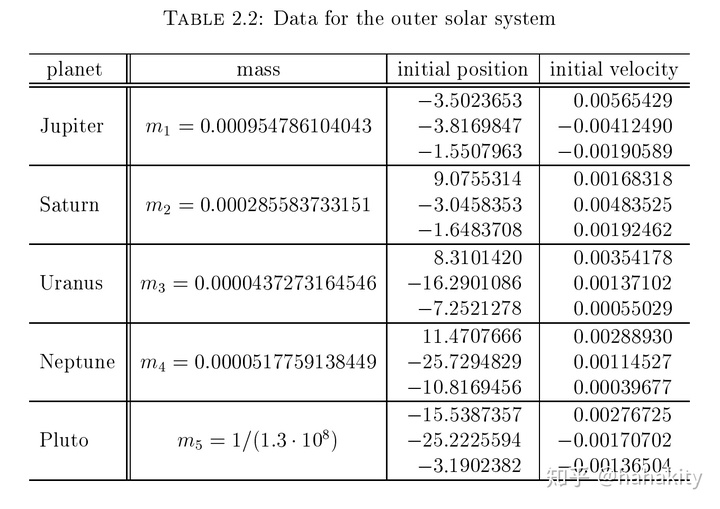

In [33]:
Image("images/solar_simulation_initial_condition.jpg", height=450)

## 哈密顿量与运动方程 

\begin{align}
H= {1 \over 2} \sum_{i=0}^5 {p_i^2 \over m_ i} - \sum_{i=0}^5 \sum_{j=0}^{i-1} {G m_im_j\over |q_i - q_j|}
\end{align}

第一项表示6个星体的动能项，第二项表示两两之间的相互作用势能。运动方程为，

\begin{align}
\dot{q_i} &= {\partial H \over \partial p_i} = p_i / m_i \\
\dot{p_i} &= - {\partial H \over \partial q_i} =- \sum_{j=0, j\neq i}^5  {q_i - q_j\over |q_i - q_j|^3}G m_im_j 
\end{align}

## 仿真步骤

1. 准备初始条件，将下表内容复制粘贴进 data/solar.csv 文件(文件已上传）

    name,mass,x,y,z,vx,vy,vz
    Sun,1.00000597682,0.0,0.0,0.0,0.0,0.0,0.0
    Jupiter,0.000954786104043,-3.5023653,-3.8169847,-1.5507963,0.00565429,-0.00412490,-0.00190589  
    Saturn, 0.000285583733151,9.0755314,-3.0458353,-1.6483708, 0.00168318,0.00483525,0.00192462
    Uranus, 0.0000437273164546,8.3101420,-16.2901086,-7.2521278,0.00354178,0.00137102,0.00055029
    Neptune,0.0000517759138449, 11.4707666,-25.7294829,-10.8169456,0.00288930,0.00114527,0.00039677
    Pluto,0.769230769E-8,-15.5387357,-25.2225594,-3.1902382,0.00276725,-0.00170702,-0.00136504


In [35]:
# 2. 使用 pandas 读入数据，设定为初始条件
solar = pd.read_csv("data/solar.csv")

In [4]:
solar.head(n=6)

,name,mass,x,y,z,vx,vy,vz
0,Sun,1.000006e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Jupiter,9.547861e-04,-3.502365,-3.816985,-1.550796,0.005654,-0.004125,-0.001906
2,Saturn,2.855837e-04,9.075531,-3.045835,-1.648371,0.001683,0.004835,0.001925
3,Uranus,4.372732e-05,8.310142,-16.290109,-7.252128,0.003542,0.001371,0.000550
4,Neptune,5.177591e-05,11.470767,-25.729483,-10.816946,0.002889,0.001145,0.000397
5,Pluto,7.692308e-09,-15.538736,-25.222559,-3.190238,0.002767,-0.001707,-0.001365


In [5]:
solar['mass']

0    1.000006e+00
1    9.547861e-04
2    2.855837e-04
3    4.372732e-05
4    5.177591e-05
5    7.692308e-09
Name: mass, dtype: float64

In [7]:
qx = solar['x']
qy = solar['y']
qz = solar['z']
mi = solar['mass'].to_numpy()
px = mi * solar['vx']
py = mi * solar['vy']
pz = mi * solar['vz']
solar['px'] = px
solar['py'] = py
solar['pz'] = pz

In [8]:
solar['mass'].sum()

1.0013418575798014

In [9]:
solar['px'].sum()

6.183816317477493e-06

In [10]:
solar['py'].sum()

-2.438293159516936e-06

In [11]:
solar['pz'].sum()

-1.2254817893370817e-06

In [12]:
solar.head()

,name,mass,x,y,z,vx,vy,vz,px,py,pz
0,Sun,1.000006,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1,Jupiter,0.000955,-3.502365,-3.816985,-1.550796,0.005654,-0.004125,-0.001906,5.398638e-06,-3.938397e-06,-1.819717e-06
2,Saturn,0.000286,9.075531,-3.045835,-1.648371,0.001683,0.004835,0.001925,4.806888e-07,1.380869e-06,5.496402e-07
3,Uranus,0.000044,8.310142,-16.290109,-7.252128,0.003542,0.001371,0.000550,1.548725e-07,5.995103e-08,2.406270e-08
4,Neptune,0.000052,11.470767,-25.729483,-10.816946,0.002889,0.001145,0.000397,1.495961e-07,5.929740e-08,2.054313e-08


In [13]:
# 准备初始位置和动量
y = solar.loc[:, ['x', 'y', 'z', 'vx', 'vy', 'vz']].to_numpy()

使用 Python 自带的 odeint(f, y0, t) 可以数值求解常微分方程。

此处，我们可以实现自己的常微分方程求解器，尽量保持接口一致。

参数都定为： 运动方程 f ，初始条件 y0 以及时间列表 t。

因为 odeint 函数的初始条件 y0 需要是一维数组，所以这里我们将6颗星体的3维坐标放在数组的前半部分，3维速度放在后半部分。

In [15]:
y0 = y[:, 0:3].flatten()

In [16]:
y0 = np.concatenate([y0, y[:, 3:].flatten()])

In [17]:
y0

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -3.50236530e+00,
       -3.81698470e+00, -1.55079630e+00,  9.07553140e+00, -3.04583530e+00,
       -1.64837080e+00,  8.31014200e+00, -1.62901086e+01, -7.25212780e+00,
        1.14707666e+01, -2.57294829e+01, -1.08169456e+01, -1.55387357e+01,
       -2.52225594e+01, -3.19023820e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  5.65429000e-03, -4.12490000e-03, -1.90589000e-03,
        1.68318000e-03,  4.83525000e-03,  1.92462000e-03,  3.54178000e-03,
        1.37102000e-03,  5.50290000e-04,  2.88930000e-03,  1.14527000e-03,
        3.96770000e-04,  2.76725000e-03, -1.70702000e-03, -1.36504000e-03])

In [19]:
# step 3, 定义运动方程

def f(y, t, dim=3):
    '''Args:
       y: one dim array that stores q and p for n particles,
        [q1_x, q1_y, q1_z, q2_x, q2_y, q2_z, ..., qn_x, qn_y, qn_z,
           p1_x, p1_y, p1_z, p2_x, p2_y, p2_z, ..., pn_x, pn_y, pn_z,]
       t: one dim array that stores time steps [t0, t1, t2, ..., tm]'''
    G = 2.95912208286E-4
    n = (len(y) // 2) // dim
    q = y[0 : dim*n].reshape(n, dim)
    p = y[dim*n:].reshape(n, dim)
    
    dot_q = np.zeros_like(q)
    dot_p = np.zeros_like(q)
    for i in range(n):
        dot_q[i] = p[i]
        for j in range(n):
            if j != i:
                # dr: the distance between 2 vectors
                Rij = np.linalg.norm(q[i]-q[j])
                dot_p[i] += - G *mi[j]* (q[i] - q[j]) / Rij**3
                
    return np.concatenate([dot_q.flatten(), dot_p.flatten()])

In [20]:
def symplectic_euler(f, y0, time):
    sol = []
    dt = time[1] - time[0]
    y = y0
    n = len(y)
    q, p = y0[:n//2], y0[n//2:]
    for t in time:
        # update p_n to p_{n+1} first
        p = p + dt * f(y, None)[n//2:]
        # update q_n next
        q = q + dt * p
        y = np.concatenate([q, p])
        sol.append(y)
    return np.array(sol)

In [21]:
def explicit_euler(f, y0, time):
    sol = []
    dt = time[1] - time[0]
    y = y0
    for t in time:
        y = y + dt * f(y, time)
        sol.append(y)
    return np.array(sol)

In [22]:
def implicit_midpoint(f, y0, time):
    sol = []
    dt = time[1] - time[0]
    y = y0
    for t in time:
        yp = y + dt * f(y, time)
        ymid = 0.5 * (y + yp)
        y = y + dt * f(ymid, time)
        sol.append(y)
    return np.array(sol)

<IPython.core.display.Javascript object>


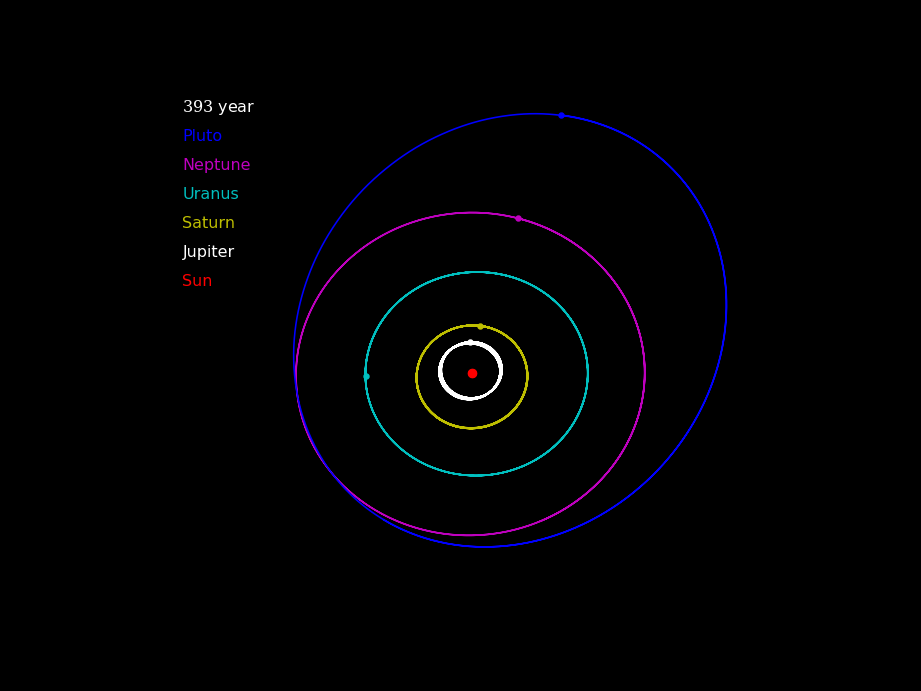

In [23]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation

plt.style.use(['dark_background', 'science', 'notebook', 'no-latex'])

tmax = 2000000
tsteps = 20000
dt = tmax / tsteps
time = np.linspace(0, tmax, tsteps)
#sol = odeint(f, y0, time)
sol = symplectic_euler(f, y0, time)
#sol = explicit_euler(f, y0, time)
#sol = implicit_midpoint(f, y0, time)

fig1, ax1 = plt.subplots()


colors = ["r", "w", "y", "c", "m", "b"]
lines = [ax1.plot(sol[0, 3*n+0], sol[0, 3*n+1], '-', lw=1, color=colors[n])[0] for n in range(6)]
marker_names = [r'o', r'o', r'o', r'o', r'o', r'o']
dots = [ax1.plot(sol[0, 3*n], sol[0, 3*n+1], 'o', color=colors[n], ms=2+np.exp(mi[n]))[0] for n in range(6)]

text = ax1.text(-50, 45, '')

def update(i):
    for ni, line in enumerate(lines):
        #t0 = max(0, i-30)
        t0 = 0
        x0 = sol[t0: i, 3*ni+0] - sol[t0:i, 0]
        y0 = sol[t0: i, 3*ni+1] - sol[t0:i, 1]
        line.set_data(x0, y0)
        dots[ni].set_data(sol[i, 3*ni] - sol[i, 0], sol[i, 3*ni+1] - sol[i, 1])
    text.set_text(r'$%d$ year'%(i*dt//365))
    return lines, dots, text,

ax1.plot(sol[0, 0], sol[0, 1], 'ro', ms=5)
ax1.set_aspect('equal')
ax1.set_xlim(-50, 50)
ax1.set_ylim(-40, 50)
ax1.axis('off')

xp = -50
plt.text(xp, 40, 'Pluto', color='b')
plt.text(xp, 35, 'Neptune', color='m')
plt.text(xp, 30, 'Uranus', color='c')
plt.text(xp, 25, 'Saturn', color='y')
plt.text(xp, 20, 'Jupiter', color='w')
plt.text(xp, 15, 'Sun', color='r')

anim = FuncAnimation(fig1, update, frames=tsteps, interval=10, blit=True)
#anim.save('images/solar_system_symplectic_centered.mp4')

plt.show()    

## 能动量、角动量守恒

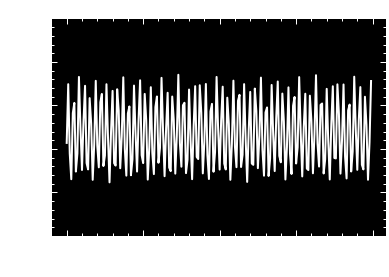

In [38]:
%matplotlib inline
# 动能守恒
def kinetic_energy(sol):
    n = len(sol[0])
    v = sol[:, n//2:]
    m = np.repeat(mi, 3)
    E = (0.5 * m * v**2).sum(axis=1)
    return E

def check_energy_conservation(E):
    plt.plot(time[::100], E[::100], 'w-')
    plt.ylim(2E-8, 4.5E-8)
    plt.xlabel('days')
    plt.ylabel('kinetic energy')
        
ke = kinetic_energy(sol)
check_energy_conservation(ke)

## 练习：地月系统模拟

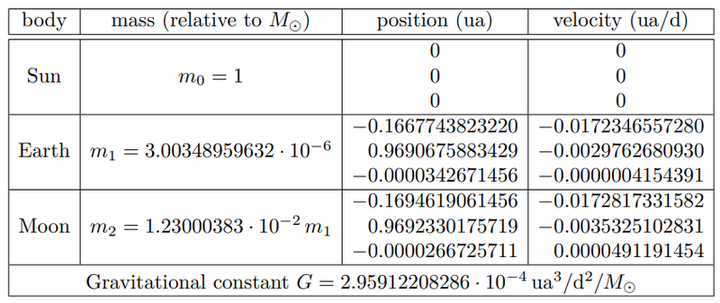

In [37]:
Image("images/earth_moon_system.png")

## 作业：重味夸克运动仿真 

Lattice QCD 计算（Quenched limit）得到重味夸克反夸克对之间的相互作用势能 Cornell Potential, 

\begin{align}
V(r) = a r - {b \over r}
\end{align}

其中 $a=0.491 GeV^2$, $b = 0.472 GeV$, 粲夸克质量 $m_c = 1.32 GeV$, 

使用 Cornell Potential 解非相对论薛定谔方程，得到哈密顿量的本质值与本征态，对应一系列重味强子的质量谱与波函数（后续课程会介绍）。

此处我们假设可以使用经典力学，模拟重味夸克的运动。作业内容如下，

1. 画出 Cornell Potential 中 V(r) 的曲线
2. 写出 $c-\bar{c}$ 在质心系中的哈密顿量，注意两体系统使用约化质量、相对距离和相对速度
3. 使用 辛欧拉算法，模拟 $c-\bar{c}$ 的运动，提供不同的初始条件，观察振动模式与转动模式

参考文献： 

https://www.hindawi.com/journals/ahep/2019/3105373/

https://en.wikipedia.org/wiki/Quarkonium

# 参考文献

https://www.math.mcgill.ca/gantumur/docs/down/Hairer9899.pdf 第 7 页


[Yoshida Symplectic Form](http://cacs.usc.edu/education/phys516/Yoshida-symplectic-PLA00.pdf)

Symplectic Geometry Algorithms for Hamiltonian Systems